# Imports

In [1]:
from myosuite.simhive.myo_sim.test_sims import TestSims as loader
from IPython.display import HTML
import matplotlib.pyplot as plt
from base64 import b64encode
import scipy.sparse as spa
from copy import deepcopy
from tqdm import tqdm
import pandas as pd
import numpy as np
import skvideo.io
import mujoco
import osqp
import os

MyoSuite:> Registering Myo Envs


libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: failed to open /dev/dri/renderD128: Permission denied

libEGL warning: NEEDS EXTENSION: falling back to kms_swrast


# Utils functions

In [2]:
def show_video(video_path, video_width = 400):
    """
    Display a video within the notebook.
    """
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")

def solve_qp(P, q, lb, ub, x0):
    """
    Solve a quadratic program.
    """
    P = spa.csc_matrix(P)
    A = spa.csc_matrix(spa.eye(q.shape[0]))
    m = osqp.OSQP()
    m.setup(P=P, q=q, A=A, l=lb, u=ub, verbose=False)
    m.warm_start(x=x0)
    res = m.solve()
    return res.x

def plot_qxxx(qxxx, joint_names, labels):
    """
    Plot generalized variables to be compared.
    qxxx[:,0,-1] = time axis
    qxxx[:,1:,n] = n-th sequence
    qxxx[:,1:,-1] = reference sequence
    """
    fig, axs = plt.subplots(4, 6, figsize=(12, 8))
    axs = axs.flatten()
    line_objects = []
    linestyle = ['-'] * qxxx.shape[2]
    linestyle[-1] = '--'
    for j in range(1, len(joint_names)+1):
        ax = axs[j-1]
        for i in range(qxxx.shape[2]):
            line, = ax.plot(qxxx[:, 0, -1], qxxx[:, j, i], linestyle[i])
            if j == 1: # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_xlim([qxxx[:, 0].min(), qxxx[:, 0].max()])
        ax.set_ylim([qxxx[:, 1:, :].min(), qxxx[:, 1:, :].max()])
        ax.set_title(joint_names[j-1])
    legend_ax = axs[len(joint_names)] # create legend in the 24th subplot area
    legend_ax.axis('off')
    legend_ax.legend(line_objects, labels, loc='center')
    plt.tight_layout()
    plt.show()

def plot_uxxx(uxxx, muscle_names, labels):
    """
    Plot actuator variables to be compared.
    uxxx[:,0,-1] = time axis
    uxxx[:,1:,n] = n-th sequence
    """
    fig, axs = plt.subplots(5, 8, figsize=(12, 8))
    axs = axs.flatten()
    line_objects = []
    for j in range(1, len(muscle_names)+1):
        ax = axs[j-1]
        for i in range(uxxx.shape[2]):
            line, = ax.plot(uxxx[:, 0, -1], uxxx[:, j, i])
            if j == 1: # add only one set of lines to the legend
                line_objects.append(line)
        ax.set_xlim([uxxx[:, 0].min(), uxxx[:, 0].max()])
        ax.set_ylim([uxxx[:, 1:, :].min(), uxxx[:, 1:, :].max()])
        ax.set_title(muscle_names[j-1])
    legend_ax = axs[len(muscle_names)] # create legend in the 40th subplot area
    legend_ax.axis('off')
    legend_ax.legend(line_objects, labels, loc='center')
    plt.tight_layout()
    plt.show()

# Introduction
In this tutorial a target trajectory will be replicated by MyoHand using MuJoCo inverse dynamics, i.e., given a sequence of joint angles *qpos*, a sequence of control *ctrl* will be generated.

In [3]:
traj = pd.read_csv('data/6_trajectory.csv').values [::200]



In [4]:
 # pd.read_csv('data/6_trajectory.csv')

# Computation of the generalized force
The computation of *ctrl* is dependent on *qfrc*, which can be obtained using inverse dynamics. Disabling the constraint solver during this phase avoids simulation divergence.

In [5]:
def get_qfrc(model, data, target_qpos):
    """
    Compute the generalized force needed to reach the target position in the next mujoco step.
    """
    data_copy = deepcopy(data)
    data_copy.qacc = (((target_qpos - data.qpos) / model.opt.timestep) - data.qvel) / model.opt.timestep
    model.opt.disableflags += mujoco.mjtDisableBit.mjDSBL_CONSTRAINT
    mujoco.mj_inverse(model, data_copy)
    model.opt.disableflags -= mujoco.mjtDisableBit.mjDSBL_CONSTRAINT
    return data_copy.qfrc_inverse

The effectiveness of the computed *qfrc* can be tested by applying it directly as shown below.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 55.44it/s]


error max (rad): 0.07674939358685849


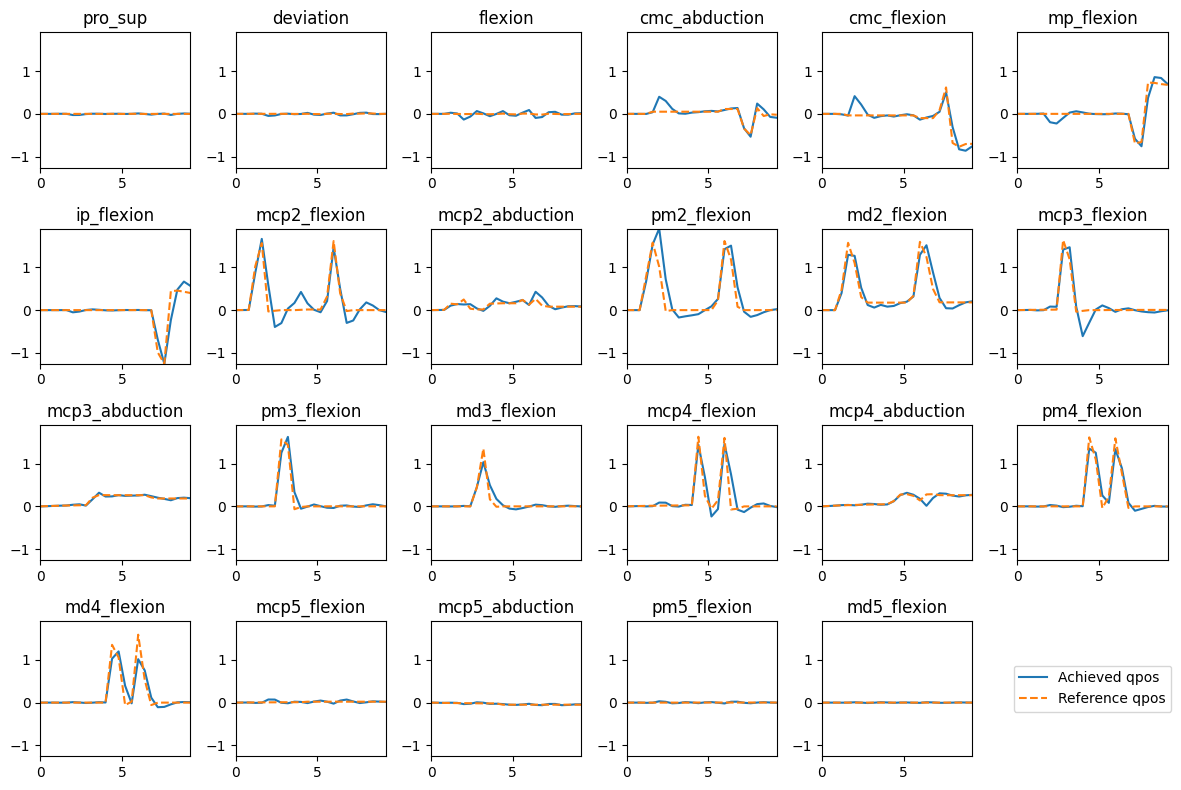

In [6]:
model0 = loader.get_sim(None, 'hand/myohand.xml')
data0 = mujoco.MjData(model0)
qpos_eval = np.zeros((traj.shape[0], traj.shape[1], 2))
qpos_eval[:,:,-1] = traj
for idx in tqdm(range(traj.shape[0])):
    target_qpos = traj[idx, 1:]
    qfrc = get_qfrc(model0, data0, target_qpos)
    data0.qfrc_applied = qfrc
    mujoco.mj_step(model0, data0)
    qpos_eval[idx,:,0] = np.hstack((data0.time, data0.qpos))
error = ((qpos_eval[:,1:,0] - qpos_eval[:,1:,-1])**2).mean(axis=0)
print(f'error max (rad): {error.max()}')
joint_names = [model0.joint(i).name for i in range(model0.nq)]
plot_qxxx(qpos_eval, joint_names, ['Achieved qpos', 'Reference qpos'])

The difference between the reference trajectory and the achieved one is practically zero. It was observed, however, that by scaling the computed *qfrc* it is possible to achieve an equally valid replication with a larger but still negligible error. Below are examples of the result that can be obtained by dividing the computed *qfrc* by 10, 100, and 1000. Among the three, using a scaler up to 100 allows good replication, while 1000 does not. The advantage in using lower *qfrc* is the easier solution of the optimization problem during the computation of *ctrl* in the next phase.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 70.36it/s]


qfrc scaler: 10 - error max (rad): 0.3366555455188718


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 63.12it/s]


qfrc scaler: 100 - error max (rad): 0.31430166746519866


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 67.54it/s]


qfrc scaler: 1000 - error max (rad): 0.3617773831009836


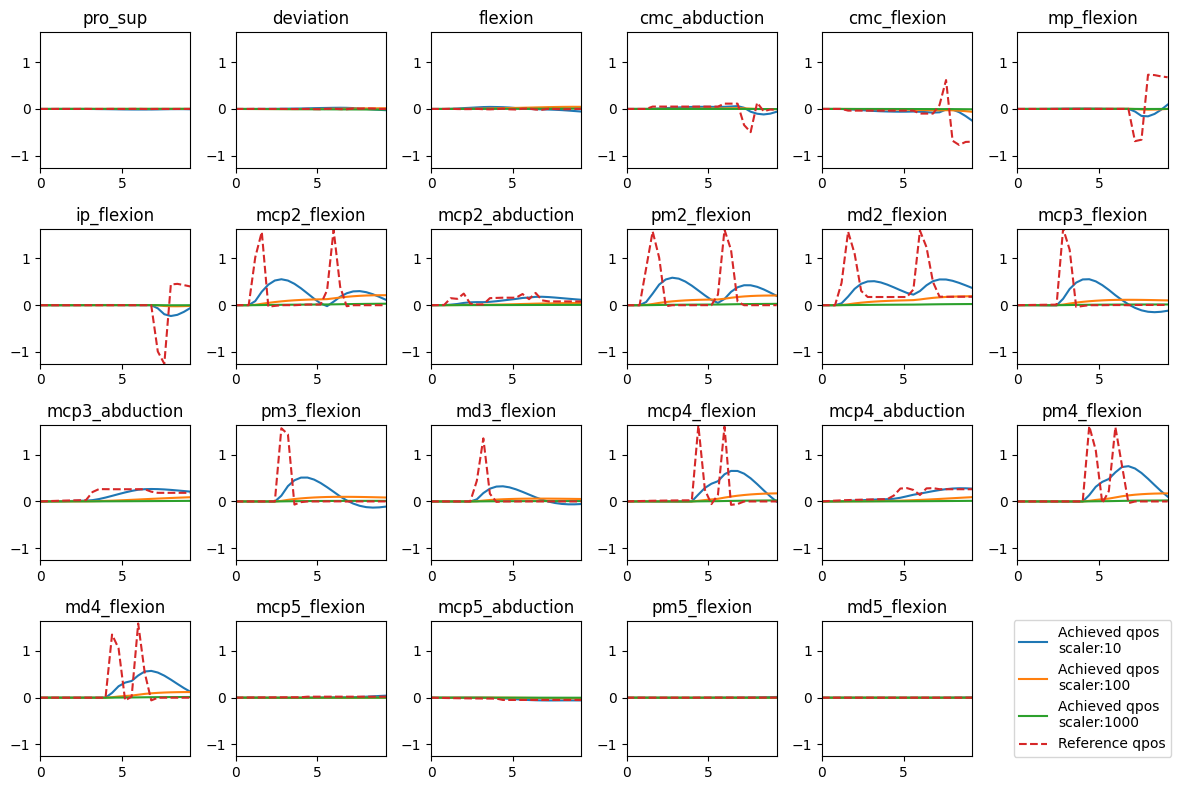

In [7]:
all_qfrc_scaler = [10, 100, 1000]
qpos_eval = np.zeros((traj.shape[0], traj.shape[1], len(all_qfrc_scaler)+1))
qpos_eval[:,:,-1] = traj
labels = []
for i_scaler, scaler in enumerate(all_qfrc_scaler):
    data0 = mujoco.MjData(model0)
    for idx in tqdm(range(traj.shape[0])):
        target_qpos = traj[idx, 1:]
        qfrc = get_qfrc(model0, data0, target_qpos)
        data0.qfrc_applied = qfrc/scaler
        mujoco.mj_step(model0, data0)
        qpos_eval[idx,:,i_scaler] = np.hstack((data0.time, data0.qpos))
    error = ((qpos_eval[:,1:,i_scaler] - qpos_eval[:,1:,-1])**2).mean(axis=0)
    print(f'qfrc scaler: {scaler} - error max (rad): {error.max()}')
    labels.append(f'Achieved qpos\nscaler:{scaler}')
labels.append('Reference qpos')
plot_qxxx(qpos_eval, joint_names, labels)

# Compuation of the control
The following describes how the ***get_ctrl*** function works.
The equation to solve for *ctrl*, accordingly to muscle actuators dynamics (https://mujoco.readthedocs.io/en/latest/modeling.html#muscles), is:
$$
AM\cdot\left(gain\odot\left(act+timestep\cdot\frac{ctrl-act}{\tau}\right)+bias\right)-qfrc=0\tag{1}
$$
where
$$
\tau=\tau_D+(\tau_A-\tau_D)\cdot sigmoid\left(\frac{ctrl-act}{tausmooth}+0.5\right)
$$
To find a solution quickly, it is better to reformulate the equation and solve a quadratic program (QP), i.e.:
$$
\min_{x} \frac{1}{2}x^TPx+q^Tx~~~s.t.~~~lb\leq x\leq ub\tag{2}
$$
The major obstacle to this formulation is the sigmoid in the calculation of $\tau$. MuJoCo implements the sigmoid using the polynomial $6x^5-15x^4+10x^3$ clipped between 0 and 1. To solve the QP, the sigmoid is approximated here with $1.875x-0.4375$ and, to limit its range for a good approximation, *tausmooth* is set to 5. The target equation can then be rewritten as:
$$
AM\cdot\left(gain\odot\left(act+timestep\cdot\frac{ctrl-act}{(ctrl-act)\cdot \tau_1+\tau_2}\right)+bias\right)-qfrc=0\tag{3}
$$
where
$$
\tau_1=\frac{\tau_A-\tau_D}{tausmooth}\cdot 1.875,~~~\tau_2=(\tau_A+\tau_D)\cdot 0.5
$$
and consequently reformulated as:
$$
AM\cdot x+k=0\tag{4}
$$
where
$$
x=\left(timestep\cdot gain\odot\frac{ctrl-act}{(ctrl-act)\cdot \tau_1+\tau_2}\right),~~~k=AM\cdot(gain\odot act)+AM\cdot bias-qfrc
$$
Referring to equation $(2)$ then:
$$
P=2\cdot AM^T\cdot AM\tag{5}
$$
$$
q=2\cdot AM^T\cdot k\tag{6}
$$
$$
lb=timestep\cdot gain\odot\frac{1-act}{(1-act)\cdot \tau_1 + \tau_2}\tag{7}
$$
$$
ub=timestep\cdot gain\odot\frac{-act}{-act\cdot \tau_1 + \tau_2}\tag{8}
$$
After solving the QP for *x*, *ctrl* is then calculated as:
$$
ctrl = act + \frac{x\cdot\tau_2}{timestep\cdot gain-x\cdot\tau_1}\tag{9}
$$

In [8]:
def get_ctrl(model, data, target_qpos, qfrc, qfrc_scaler, qvel_scaler):
    """
    Compute the control needed to reach the target position in the next mujoco step.
    qfrc: generalized force resulting from inverse dynamics.
    """
    act = data.act
    ctrl0 = data.ctrl
    ts = model.opt.timestep
    tA = model.actuator_dynprm[:,0] * (0.5 + 1.5 * act)
    tD = model.actuator_dynprm[:,1] / (0.5 + 1.5 * act)
    tausmooth = model.actuator_dynprm[:,2]
    t1 = (tA - tD) * 1.875 / tausmooth
    t2 = (tA + tD) * 0.5
    # ---- gain, bias, and moment computation
    data_copy = deepcopy(data)
    data_copy.qpos = target_qpos
    data_copy.qvel = ((target_qpos - data.qpos) / model.opt.timestep) / qvel_scaler
    mujoco.mj_step1(model, data_copy) # gain, bias, and moment depend on qpos and qvel
    gain = np.zeros(model.nu)
    bias = np.zeros(model.nu)
    for idx_actuator in range(model.nu):
        length = data_copy.actuator_length[idx_actuator]
        lengthrange = model.actuator_lengthrange[idx_actuator]
        velocity = data_copy.actuator_velocity[idx_actuator]
        acc0 = model.actuator_acc0[idx_actuator]
        prmb = model.actuator_biasprm[idx_actuator,:9]
        prmg = model.actuator_gainprm[idx_actuator,:9]
        bias[idx_actuator] = mujoco.mju_muscleBias(length, lengthrange, acc0, prmb)
        gain[idx_actuator] = min(-1, mujoco.mju_muscleGain(length, velocity, lengthrange, acc0, prmg))
    AM = data_copy.actuator_moment.T
    # ---- ctrl computation
    P = 2 * AM.T @ AM
    k = AM @ (gain * act) + AM @ bias - (qfrc / qfrc_scaler)
    q = 2 * k @ AM
    lb = gain * (1 - act) * ts / (t2 + t1 * (1 - act))
    ub = - gain * act * ts / (t2 - t1 * act)
    x0 = (gain * (ctrl0 - act) * ts) / ((ctrl0 - act) * t1 + t2)
    x = solve_qp(P, q, lb, ub, x0)
    ctrl = act + x * t2 / (gain * ts - x * t1)
    return np.clip(ctrl,0,1)

The *ctrl* sequence to be applied to MyoHand in order to replicate the reference trajectory can thus be achieved.

In [9]:
model1 = loader.get_sim(None, 'hand/myohand.xml')
tausmooth = 5
model1.actuator_dynprm[:,2] = tausmooth
data1 = mujoco.MjData(model1)
all_ctrl = np.zeros((traj.shape[0], 1+model1.nu))
for idx in tqdm(range(traj.shape[0])):
    target_qpos = traj[idx, 1:]
    qfrc = get_qfrc(model1, data1, target_qpos)
    ctrl = get_ctrl(model1, data1, target_qpos, qfrc, 100, 5)
    data1.ctrl = ctrl
    mujoco.mj_step(model1, data1)
    all_ctrl[idx,:] = np.hstack((data1.time, ctrl))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 21.21it/s]


The use of a new scaler is also included in this phase. Indeed, it was observed that by reducing the velocity set for *gain* computation, the obtained *ctrl* is more stable. Below is an example to compare the results using a scaler equal to 5.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 18.78it/s]


qvel scaler: 1 - error max (rad): 0.3671978415102481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 16.42it/s]


qvel scaler: 5 - error max (rad): 0.3667688845051969


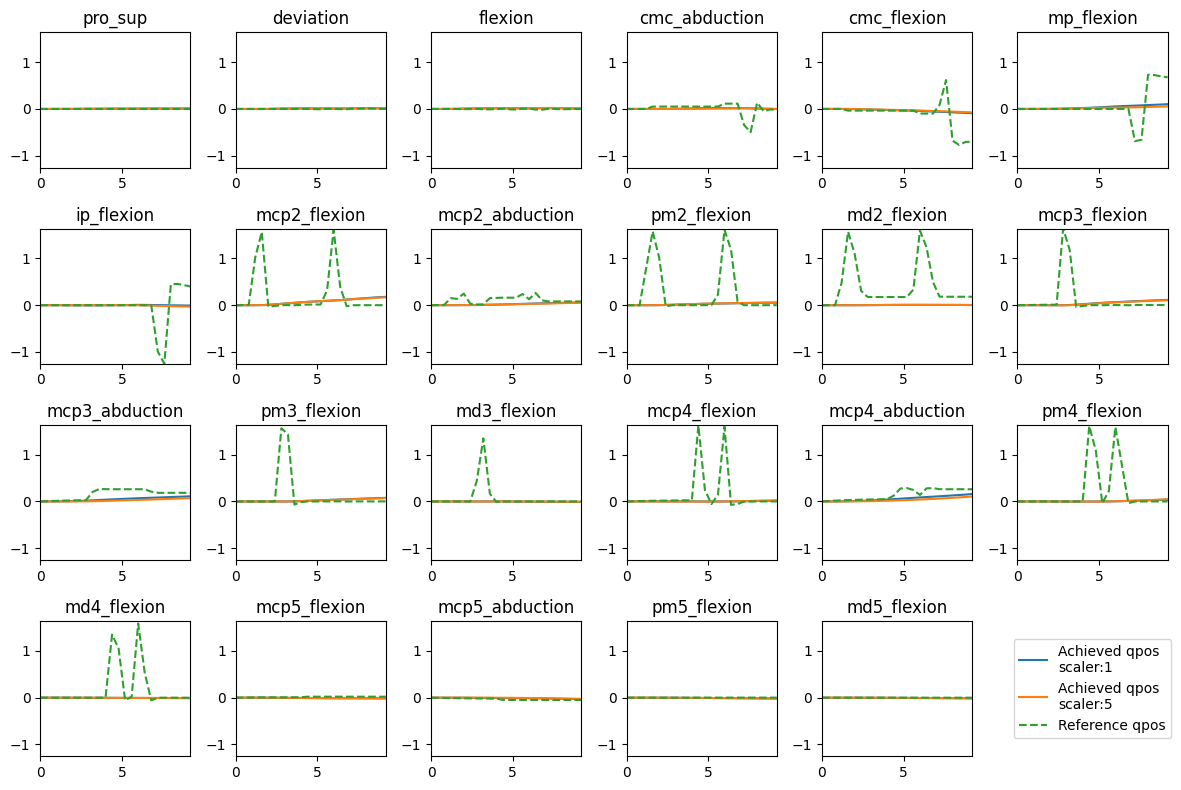

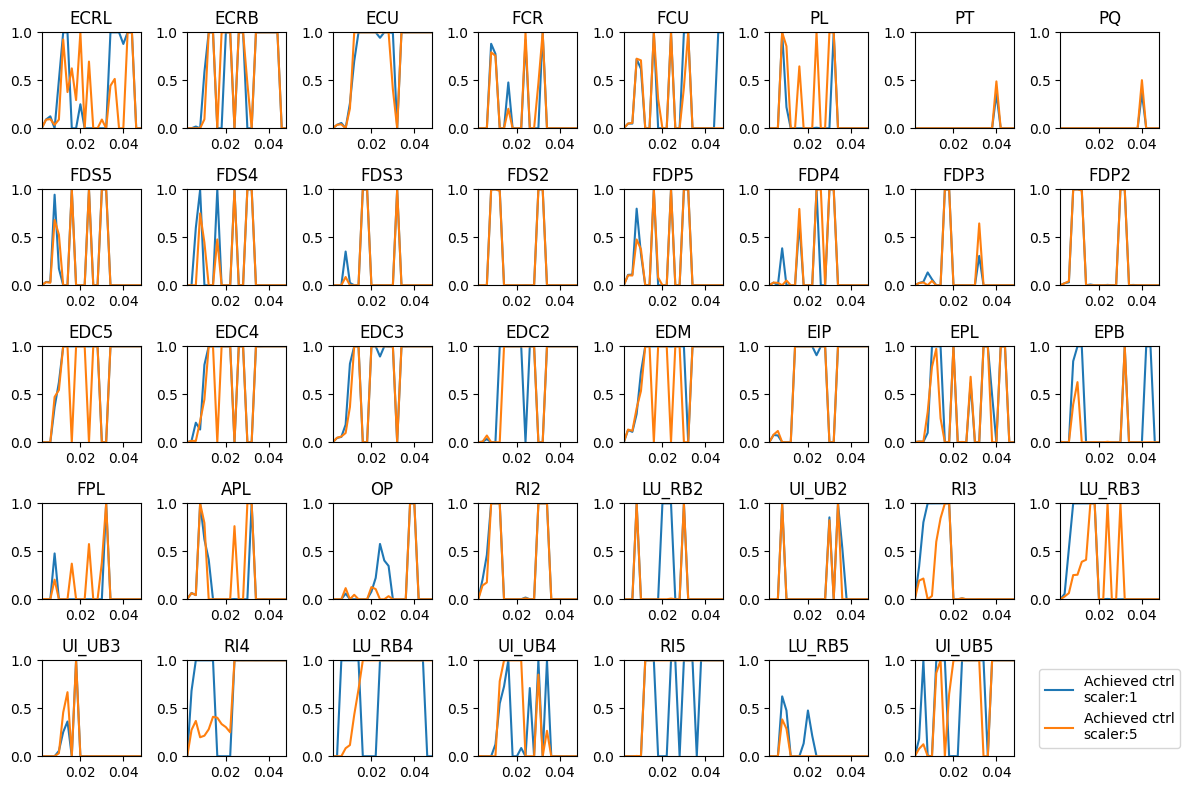

In [10]:
all_qvel_scaler = [1, 5]
qpos_eval = np.zeros((traj.shape[0], traj.shape[1], len(all_qvel_scaler)+1))
qpos_eval[:,:,-1] = traj
labels_qxxx = []
ctrl_eval = np.zeros((traj.shape[0], 1+model1.nu, len(all_qvel_scaler)))
labels_uxxx = []
for i_scaler, scaler in enumerate(all_qvel_scaler):
    data1 = mujoco.MjData(model1)
    for idx in tqdm(range(traj.shape[0])):
        target_qpos = traj[idx, 1:]
        qfrc = get_qfrc(model1, data1, target_qpos)
        ctrl = get_ctrl(model1, data1, target_qpos, qfrc, 100, scaler)
        data1.ctrl = ctrl
        mujoco.mj_step(model1, data1)
        qpos_eval[idx,:,i_scaler] = np.hstack((data1.time, data1.qpos))
        ctrl_eval[idx,:,i_scaler] = np.hstack((data1.time, ctrl))
    error = ((qpos_eval[:,1:,i_scaler] - qpos_eval[:,1:,-1])**2).mean(axis=0)
    print(f'qvel scaler: {scaler} - error max (rad): {error.max()}')
    labels_qxxx.append(f'Achieved qpos\nscaler:{scaler}')
    labels_uxxx.append(f'Achieved ctrl\nscaler:{scaler}')
labels_qxxx.append('Reference qpos')
joint_names = [model1.joint(i).name for i in range(model0.nq)]
plot_qxxx(qpos_eval, joint_names, labels_qxxx)
muscle_names = [model1.actuator(i).name for i in range(model0.nu)]
plot_uxxx(ctrl_eval, muscle_names, labels_uxxx)

# Results
The trajectory achievable by applying the *ctrl* sequence resulting from the previous block is compared below with the reference trajectory.

In [11]:
# ---- initializations
model_ref = loader.get_sim(None, 'hand/myohand.xml')
model_ref.actuator_dynprm[:,2] = tausmooth
data_ref = mujoco.MjData(model_ref) # data for reference trajectory
model_test = loader.get_sim(None, 'hand/myohand.xml')
model_test.actuator_dynprm[:,2] = tausmooth
data_test = mujoco.MjData(model_test) # test data for achieved trajectory
# ---- camera settings
camera = mujoco.MjvCamera()
camera.azimuth = 166.553
camera.distance = 1.178
camera.elevation = -36.793
camera.lookat = np.array([-0.93762553, -0.34088276, 0.85067529])
options_ref = mujoco.MjvOption()
options_ref.flags[:] = 0
options_ref.geomgroup[1:] = 0
options_test = mujoco.MjvOption()
options_test.flags[:] = 0
options_test.flags[4] = 1 # actuator ON
options_test.geomgroup[1:] = 0
renderer_ref = mujoco.Renderer(model_ref)
renderer_ref.scene.flags[:] = 0
renderer_test = mujoco.Renderer(model_test)
renderer_test.scene.flags[:] = 0
# ---- generation loop
frames = []
for idx in tqdm(range(traj.shape[0])):
    # -- reference trajectory
    data_ref.qpos = traj[idx, 1:]
    mujoco.mj_step1(model_ref, data_ref)
    # -- achieved trajectory
    data_test.ctrl = all_ctrl[idx, 1:]
    mujoco.mj_step(model_test, data_test)
    # -- frames generation
    if not idx % round(0.3/(model_test.opt.timestep*25)):
        renderer_ref.update_scene(data_ref, camera=camera, scene_option=options_ref)
        frame_ref = renderer_ref.render()
        renderer_test.update_scene(data_test, camera=camera, scene_option=options_test)
        frame_test = renderer_test.render()
        frame_merged = np.append(frame_ref, frame_test, axis=1)
        frames.append(frame_merged)
# -- frames writing
os.makedirs('videos', exist_ok = True)
output_name = 'videos/myohand_freemovement.mp4'
skvideo.io.vwrite(output_name, np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00,  8.23it/s]


In [12]:
show_video(output_name)

Left, reference trajectory. Right, achieved trajectory.